In [1]:
import yaml
import numpy as np


### Loading an experiment file

In [2]:
def read_experiments(filename, verbose=True):
    with open(r''+filename) as file:
        experiments = yaml.full_load(file)
        if verbose :
            for exp, content in experiments.items():
                print(key, ":", content)
        return experiments

In [3]:
exp = read_experiments('exp.yaml', False)

In [4]:
exp

{'Experience1': {'nb_steps': 1000,
  'nb_sync': 100,
  'tasks': 3,
  'Type1': {'number': 3,
   'type': 'RegretMatching',
   'spec': {'intertia': 0.1, 'fadding': 0.2}},
  'Type2': {'number': 2, 'type': 'FictiousPlay'},
  'Type3': {'number': 3, 'type': 'Random'}},
 'Experience2': {'tasks': 3,
  'Type1': {'number': 3,
   'type': 'RegretMatching',
   'spec': {'intertia': 0.1, 'fadding': 0.2}},
  'Type2': {'number': 2, 'type': 'FictiousPlay'},
  'Type3': {'number': 1, 'type': 'Random'}}}

### Generating experiments (all combinations)

In [5]:
# Available Agent Types :
types = {0 : "RegretMatching", 1 : "FictitiousPlay", 2 : "Random", 3 : "BestResponse", 
         4 : "SpacialAdaptative"}

In [6]:
nb_vehicles = 3 # for 3 vehicles and 4 tasks, 125 possible combinations
nb_tasks = 4

In [7]:
alloc_dim = np.zeros([len(types)]*nb_vehicles)

In [8]:
alloc_dim.shape

(5, 5, 5)

In [9]:
allAlloc = [x for x,_ in np.ndenumerate(alloc_dim)]

In [10]:
len(allAlloc)

125

#### Creating an experiment file containing an experiment for each possible combination with 5 possible types of players, with 4 tasks and 3 players.

In [11]:
def create_experiments(nb_steps, nb_agents, nb_tasks, nb_sync=100):
    # Available Types :
    types = {0 : "RegretMatching", 1 : "FictitiousPlay", 2 : "Random", 3 : "BestResponse", 
         4 : "SpatialAdaptative"}
    alloc_dim = np.zeros([len(types)]*nb_vehicles)
    allAlloc = [x for x,_ in np.ndenumerate(alloc_dim)]
    repartitions = []
    exp = {}
    expId = 1
    for a in allAlloc:
        seen = []
        exp_dict = {}
        exp_dict['nb_sync'] = int(nb_sync)
        exp_dict['tasks'] = int(nb_tasks)
        typeId = 1
        repartition = np.zeros(len(types))
        for t in a :
            type_dict={}
            str_type = types[t]
            #print(seen)
            if str_type not in seen :
                seen.append(str_type)
                type_dict["type"] = str_type
                cnt = int((np.array(a)==t).sum())
                type_dict["number"] = cnt
                repartition[t] = cnt
                if str_type == "RegretMatching":
                    # default values
                    dict_spec = {"inertia": 0.1, "fadding" : 0.2}
                    type_dict["spec"] = dict_spec
                # save the agent params
                exp_dict["Type"+str(typeId)] = type_dict
                typeId += 1
        already_done = np.sum([1 if np.all(repartition == r) else 0 for r in repartitions])
        if already_done < 1 :
            # save the experiment setup
            exp["Experience"+str(expId)] = exp_dict
            expId += 1
            # remember done repartitions
            repartitions.append(repartition)
            #print(repartitions)
    return exp

#### The obtained dict (containing all the experiments setup)

In [12]:
exp_outp = create_experiments(100, 3, 4, nb_sync=100)

In [13]:
exp_outp

{'Experience1': {'nb_sync': 100,
  'tasks': 4,
  'Type1': {'type': 'RegretMatching',
   'number': 3,
   'spec': {'inertia': 0.1, 'fadding': 0.2}}},
 'Experience2': {'nb_sync': 100,
  'tasks': 4,
  'Type1': {'type': 'RegretMatching',
   'number': 2,
   'spec': {'inertia': 0.1, 'fadding': 0.2}},
  'Type2': {'type': 'FictitiousPlay', 'number': 1}},
 'Experience3': {'nb_sync': 100,
  'tasks': 4,
  'Type1': {'type': 'RegretMatching',
   'number': 2,
   'spec': {'inertia': 0.1, 'fadding': 0.2}},
  'Type2': {'type': 'Random', 'number': 1}},
 'Experience4': {'nb_sync': 100,
  'tasks': 4,
  'Type1': {'type': 'RegretMatching',
   'number': 2,
   'spec': {'inertia': 0.1, 'fadding': 0.2}},
  'Type2': {'type': 'BestResponse', 'number': 1}},
 'Experience5': {'nb_sync': 100,
  'tasks': 4,
  'Type1': {'type': 'RegretMatching',
   'number': 2,
   'spec': {'inertia': 0.1, 'fadding': 0.2}},
  'Type2': {'type': 'SpatialAdaptative', 'number': 1}},
 'Experience6': {'nb_sync': 100,
  'tasks': 4,
  'Type1': {

### Saving an experiment file

In [14]:
def write_exp_file(filename, exp):
    with open(r''+str(filename), 'w') as file:
        yaml.dump(exp, file)

In [15]:
write_exp_file("exp_3vehicles_4tasks.yaml", exp_outp)

### Run an experiment from yaml file

In [16]:
import threading
import time
import logging
from Environnement import *
from Simulation import *
from Player import *
from utils import *
from Functions import *
import re

"""logging.basicConfig(level=logging.DEBUG,
                    format='[%(levelname)s] (%(threadName)) : %(message)s',
                    )"""


"logging.basicConfig(level=logging.DEBUG,\n                    format='[%(levelname)s] (%(threadName)) : %(message)s',\n                    )"

#### Reading the experiment saved just before

In [17]:
myexp = read_experiments("exp_3vehicles_4tasks.yaml", False)

In [18]:
print(myexp)

{'Experience1': {'Type1': {'number': 3, 'spec': {'fadding': 0.2, 'inertia': 0.1}, 'type': 'RegretMatching'}, 'nb_sync': 100, 'tasks': 4}, 'Experience10': {'Type1': {'number': 1, 'spec': {'fadding': 0.2, 'inertia': 0.1}, 'type': 'RegretMatching'}, 'Type2': {'number': 2, 'type': 'Random'}, 'nb_sync': 100, 'tasks': 4}, 'Experience11': {'Type1': {'number': 1, 'spec': {'fadding': 0.2, 'inertia': 0.1}, 'type': 'RegretMatching'}, 'Type2': {'number': 1, 'type': 'Random'}, 'Type3': {'number': 1, 'type': 'BestResponse'}, 'nb_sync': 100, 'tasks': 4}, 'Experience12': {'Type1': {'number': 1, 'spec': {'fadding': 0.2, 'inertia': 0.1}, 'type': 'RegretMatching'}, 'Type2': {'number': 1, 'type': 'Random'}, 'Type3': {'number': 1, 'type': 'SpatialAdaptative'}, 'nb_sync': 100, 'tasks': 4}, 'Experience13': {'Type1': {'number': 1, 'spec': {'fadding': 0.2, 'inertia': 0.1}, 'type': 'RegretMatching'}, 'Type2': {'number': 2, 'type': 'BestResponse'}, 'nb_sync': 100, 'tasks': 4}, 'Experience14': {'Type1': {'number'

#### Simple factory to create the actor we want

In [19]:
def getAgent(env, id_a, type_a, fadding = 0, inertia = 0):
    if type_a == "Random":
        return RandomPlayer(env, id_a)
    if type_a == "FictitiousPlay":
        return FPPlayer(env, id_a)
    if type_a == "RegretMatching":
        return RegretMatchingPlayer(env, id_a)
    if type_a == "BestResponse":
        return BRPlayer(env, id_a)
    if type_a == "SpatialAdaptative":
        return SAPlayer(env, id_a)
    if type_a == "SpatialFictitious":
        return SpatialFictiousPlayPlayer(env, id_a)
    if type_a == "GeneralizedRegret":
        return GeneralizedRegretMatchingPlayer(env, id_a, fadding_factor = fadding, inertia_factor = inertia)

#### We define the metric we use for the plot

In [20]:
def metric(m, utilities):
    if m == "sum":
        return np.sum(utilities)
    # TODO : add other metrics

#### We run the experiments (plots in the output)

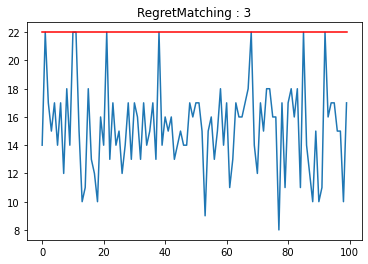

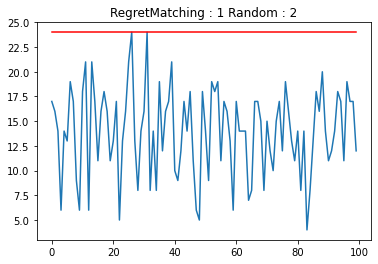

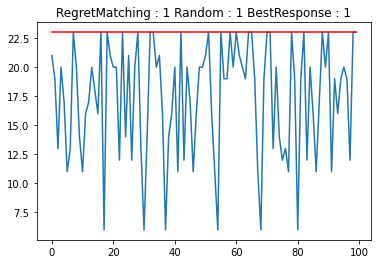

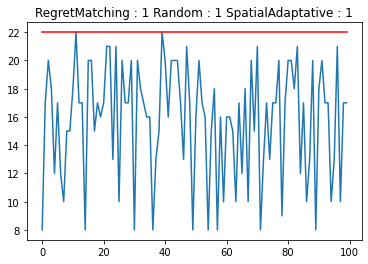

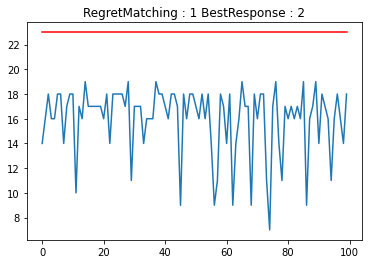

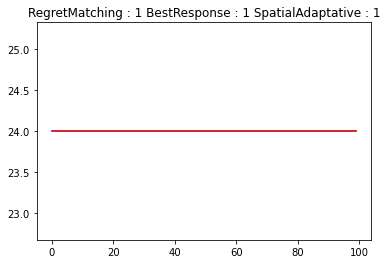

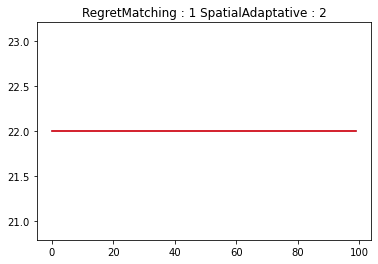

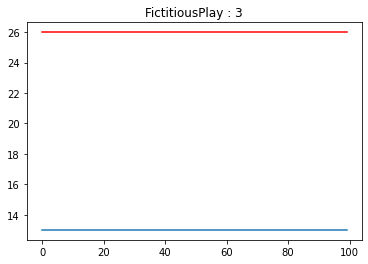

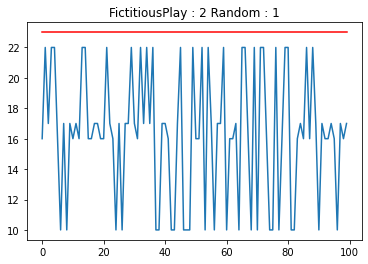

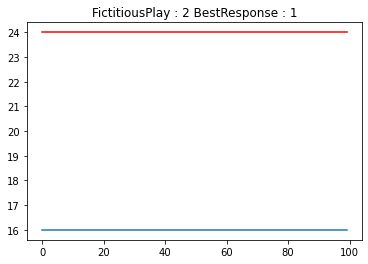

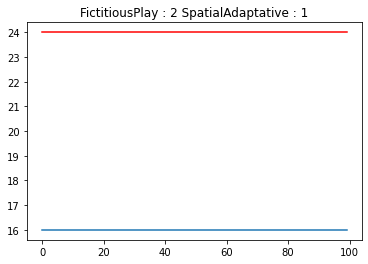

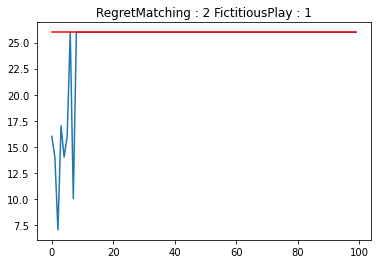

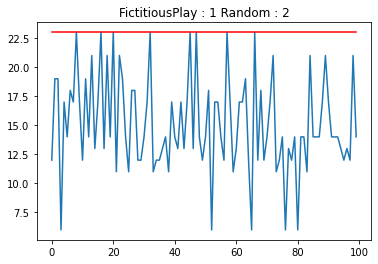

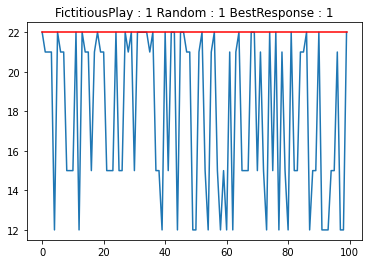

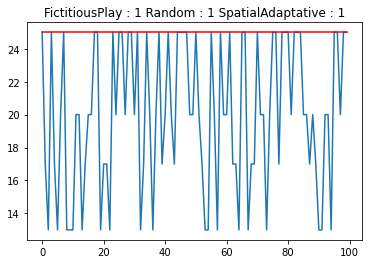

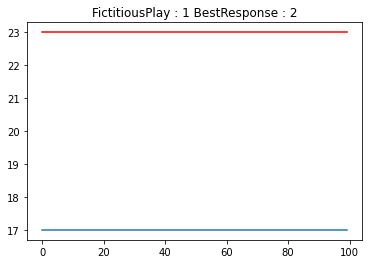

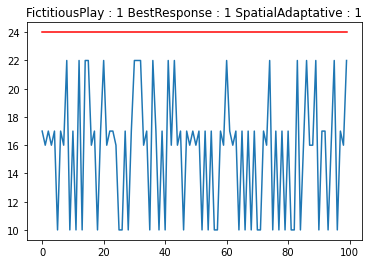

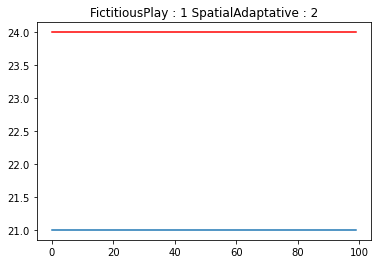

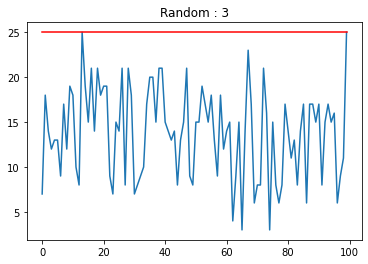

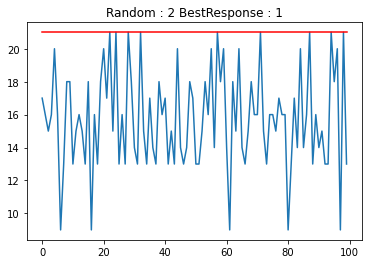

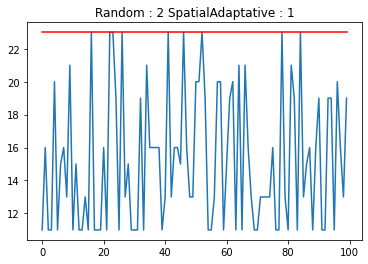

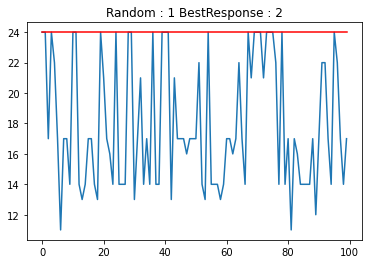

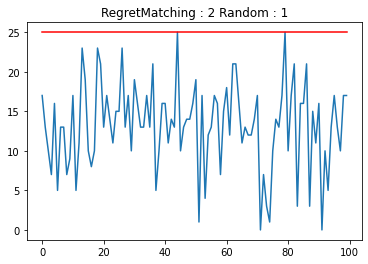

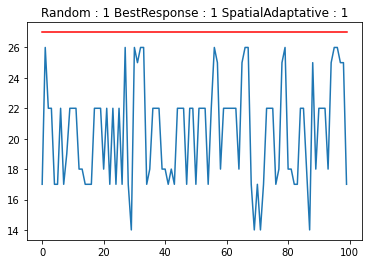

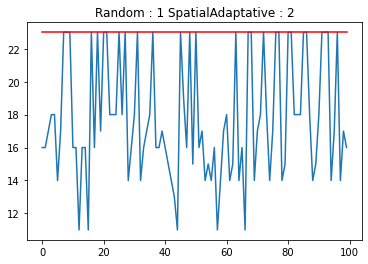

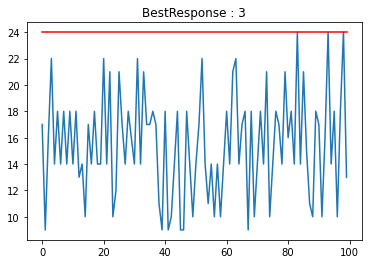

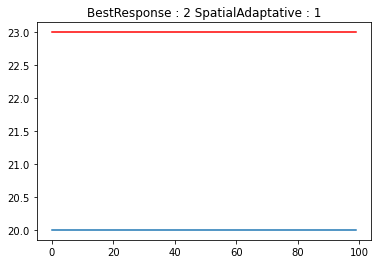

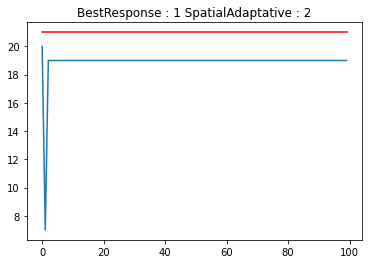

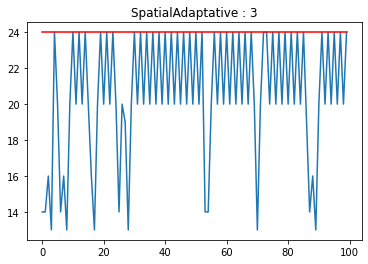

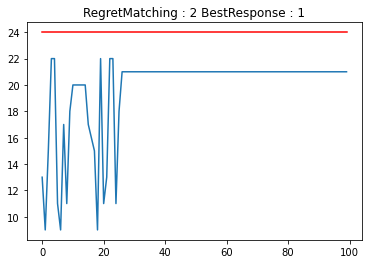

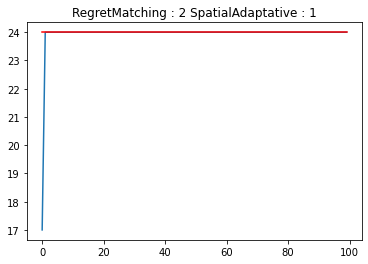

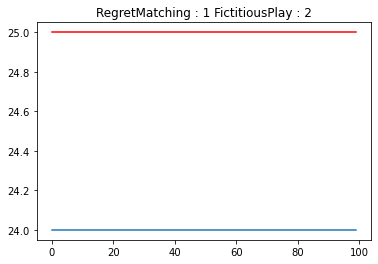

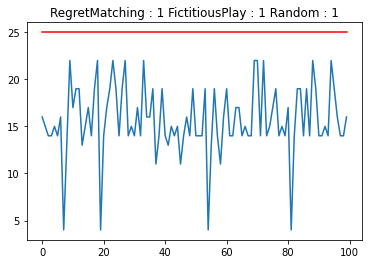

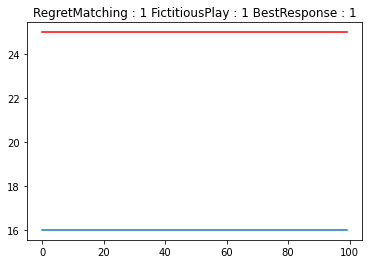

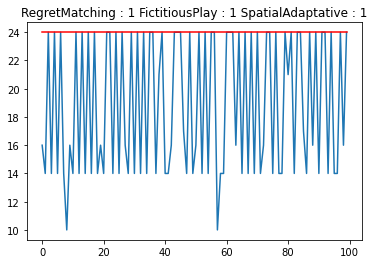

In [21]:
import matplotlib.pyplot as plt 
logging.basicConfig(level=logging.ERROR,
                    format='[%(levelname)s] (%(threadName)) : %(message)s',
                    )
# run all the experiments and plot the curve
for exp in myexp.keys():
    utility_evolution = []
    #print(exp)
    nb_sync = myexp[exp]["nb_sync"]
    nb_tasks = myexp[exp]["tasks"]
    agents = []
    entrys = myexp[exp].keys()
    #print(entrys)
    res = []
    for i in entrys : # search for Type definitions only
        if len(re.findall('Type*', i)) > 0 :
            res.append(i)
    total_agents = 0
    for t in res :
        nb_t = myexp[exp][t]["number"] # number of agents of this type
        total_agents += nb_t
    #print(total_agents)
    env = Environnement(nb_tasks,total_agents, utilities = getEqualySharedUt(total_agents, nb_tasks,(0,10))) #creating the environment
    for t in res :
        if np.isin("spec",myexp[exp][t].keys()): # check if extra parameters
            fadding = myexp[exp][t]["spec"]["fadding"]
            inertia = myexp[exp][t]["spec"]["inertia"]
        else:
            fadding = 0
            inertia = 0
        for j in range(myexp[exp][t]["number"]): #create X agents of this type
            ag = getAgent(env, len(agents),myexp[exp][t]["type"], fadding, inertia)
            agents.append(ag)
    #print(agents)
    for steps in range(100):
        threads = []
        for a in agents : # getting agent threads
            t = threading.Thread(name="Player "+str(a.id), target=a.getWorkerFunction(5,verbose=False))
            threads.append(t)
        for th in threads : #starting the threads
            th.start()
        for th in threads : # join all (wait all ended)
            th.join()
        currentAlloc = env.allocation
        #print("alloc : "+str(currentAlloc))
        currentUt = env.utility[tuple(currentAlloc)]
        #print("utility : "+str(currentUt))
        utility_evolution.append(metric("sum", currentUt))
    plt.figure()
    plt.plot(list(range(len(utility_evolution))), utility_evolution)
    plt.plot(list(range(len(utility_evolution))), len(utility_evolution)*[env.global_opt], c="red")
    plt.title(" ".join([myexp[exp][t]["type"] + " : "+ str(myexp[exp][t]["number"]) for t in res]))
    plt.show()
    #print(env.is_EN())

AxisError: axis 4 is out of bounds for array of dimension 4